In [1]:
import torch
from torch import nn
import torchvision

print(f"Pytorch version:{torch.__version__}\n torchvision version:{torchvision.__version__}")

Pytorch version:2.2.1+cu121
 torchvision version:0.17.1+cu121


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 归一化
])

# 加载 CIFAR-10 数据集
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 打印数据集大小
print('训练集大小:', len(train_dataset))
print('验证集大小:', len(val_dataset))
print('测试集大小:', len(test_dataset))

# 打印类别标签
classes = dataset.classes
print('类别标签:', classes)

#数据集查看
image, label = train_dataset[0]

# image, label #查看第一条训练数据
image.shape  #查看数据的形状


训练集大小: 40000
验证集大小: 10000
测试集大小: 10000
类别标签: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (3, 32, 32)
label:6


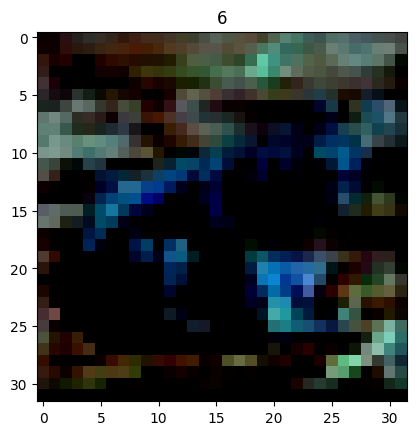

In [3]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[0]

# 确保图像数据类型为 NumPy 数组
image = np.array(image)

# 显示图像
print(f"Image shape: {image.shape}")
print(f"label:{label}")
plt.imshow(image.transpose(1, 2, 0))
plt.title(label)
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def print_loss(losses, string):
    # 绘制损失图
    plt.plot(losses, label=string)  # 绘制损失曲线
    plt.title(string)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()  # 添加图例
    plt.show()  # 显示图像

In [6]:
def test_data(model, test_loader, criterion):
    losses = []
    model.to(device)
    model.eval()  # 设置模型为评估模式
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 不计算梯度
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())
    print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {(correct/total)*100:.2f}%")
    return losses
    

In [7]:
from torch.utils.data import DataLoader, random_split

# 设置批处理大小超参数
BATCH_SIZE = 64

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#打印结果
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of 训练集: {len(train_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 验证集: {len(val_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 测试集: {len(test_loader)}, batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000020C7E62F390>, <torch.utils.data.dataloader.DataLoader object at 0x0000020C7E62FFD0>)
Length of 训练集: 625, batches of 64
Length of 验证集: 157, batches of 64
Length of 测试集: 157, batches of 64


## Resnet9

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 批归一化层对每个输入通道进行归一化处理，以减少内部协变量偏移（Internal Covariate Shift）。
# 在深度网络中，由于每一层的输入分布可能会发生变化，导致网络参数的更新变得困难，进而影响训练效果。
# 批归一化通过将每个通道的输入归一化为均值为 0、标准差为 1 的分布，使得每层网络的输入更加稳定，有助于加速网络的训练过程。

class ResidualBlock(nn.Module):   # 不带瓶颈层的残差块
    def __init__(self, in_channels, out_channels, stride=1):  
        super(ResidualBlock, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)  
        self.bn1 = nn.BatchNorm2d(out_channels)  # 批归一化
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(out_channels)  # 批归一化
        self.relu = nn.ReLU(inplace=True)  # ReLU 激活函数
        self.stride = stride  

        # 残差连接根据输入输出通道数是否改变或者步长是否为 1，来决定是使用线性投影还是恒等映射
        if stride != 1 or in_channels != out_channels: 
            self.shortcut = nn.Sequential(            
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()  

    def forward(self, x):  
        residual = x  # 残差

        out = self.conv1(x)  
        out = self.bn1(out)  
        out = self.relu(out) 

        out = self.conv2(out)  
        out = self.bn2(out)  

        # 快捷连接
        residual = self.shortcut(residual)

        out += residual  
        out = self.relu(out)  

        return out  

class ResNet9(nn.Module):  
    def __init__(self, num_classes=10): 
        super(ResNet9, self).__init__()  
        self.prep = nn.Sequential(  # 预处理层
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True)  
        )
        # -> (64, 32, 32)
        self.layer1 = self._make_layer_1(64, 128, stride=1)  # ->(128, 16, 16)
        self.layer2 = self._make_layer_2(128, 256, stride=1) # ->(256, 8, 8)
        self.layer3 = self._make_layer_3(256, 512, stride=1) # ->(512, 4, 4)
        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=4, stride=4),  # 最大池化层将图片尺寸减小为 1x1
            nn.Flatten(),  # 将张量展平为一维向量
            nn.Linear(512, num_classes)  # 全连接层将输出维度从 512 减小到 num_classes
        )

    def _make_layer_1(self, in_channels, out_channels, stride):  # 创建残差块函数
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        # 添加最大池化层
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        # 添加残差块
        layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)  # 返回序列化的残差块

    def _make_layer_2(self, in_channels, out_channels, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)  # 返回序列化的残差块

    def _make_layer_3(self, in_channels, out_channels, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        # 添加最大池化层
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        # 添加残差块
        layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)  # 返回序列化的残差块


    def forward(self, x):  
        out = self.prep(x)  
        out = self.layer1(out)  
        out = self.layer2(out)  
        out = self.layer3(out)  
        out = self.classifier(out)  # 分类器层
        return F.log_softmax(out, dim=1)  # 对输出进行 log_softmax 处理

# 创建 ResNet-9 模型实例
resnet9 = ResNet9()
# 打印模型结构
print(resnet9)


ResNet9(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequenti

In [9]:
import math
def get_cosine_schedule_with_warmup(
    learning_rate, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            lr = float(current_step) / (float(max(1, num_warmup_steps)))
            lr = lr + 0.01
            return lr
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    lrs = []
    for current_step in range(num_training_steps):
        cur_lr = lr_lambda(current_step) * learning_rate
        lrs.append(cur_lr)
    return lrs

total_batches = len(train_loader) * 20  # 计算总共的训练批次数
warmup_steps = int(total_batches * (0.3))
print(len(train_loader))
print(total_batches)
print(warmup_steps)

lr_schedule = get_cosine_schedule_with_warmup(0.01, warmup_steps, total_batches)
print(len(lr_schedule))

625
12500
3750
12500


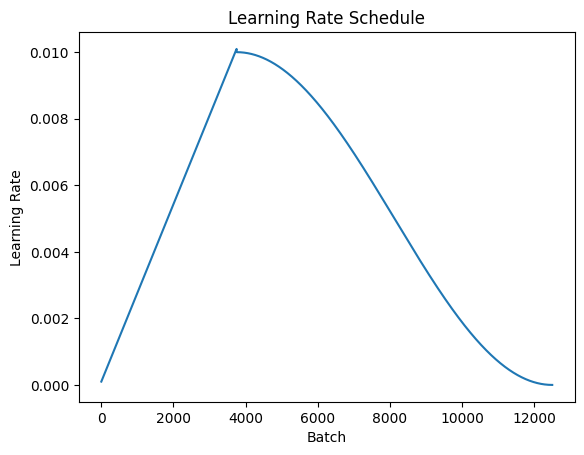

In [10]:
def plot_lr(lr_history):
    plt.plot(lr_history)
    plt.xlabel('Batch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

plot_lr(lr_schedule)

In [11]:

# 定义训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    losses = []
    model.to(device)

    total_batches = len(train_loader) * num_epochs  # 计算总共的训练批次数
    warmup_steps = int(total_batches * (0.3))
    base_lr = 0.01
    lr_schedule = get_cosine_schedule_with_warmup(base_lr, warmup_steps, total_batches)
    # print(len(lr_schedule))
    
    for epoch in range(num_epochs):
        idx = 0
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 梯度清零
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 参数更新
            running_loss += loss.item()
            losses.append(loss.item())
            # 更新学习率并记录学习率的变化
            current_step = epoch * len(train_loader) + idx
            lr = lr_schedule[current_step]
            if idx % 300 == 0:
                print(f"loss_{idx}={loss}")
            idx = idx + 1
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        # 打印每个epoch的训练损失
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}")

        # 在验证集上评估模型
        model.eval()  # 设置模型为评估模式
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # 打印每个epoch的验证损失和准确率
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {(correct/total)*100:.2f}%")

    return losses



In [12]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(resnet9.parameters(), lr=0.001, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model_Res.parameters(), lr=0.001)

val_losses = train_model(resnet9, train_loader, val_loader, criterion, optimizer, num_epochs=20)

loss_0=3.405961513519287
loss_300=1.5354329347610474
loss_600=1.0797228813171387
Epoch 1, Train Loss: 1.3214236289024353
Epoch 1, Validation Loss: 0.9558250429523978, Validation Accuracy: 66.29%
loss_0=0.8950620889663696
loss_300=0.954979419708252
loss_600=0.6018146872520447
Epoch 2, Train Loss: 0.887731547164917
Epoch 2, Validation Loss: 1.105503118721543, Validation Accuracy: 66.05%
loss_0=0.9328910708427429
loss_300=1.0020947456359863
loss_600=0.6541675925254822
Epoch 3, Train Loss: 0.7370531705379486
Epoch 3, Validation Loss: 0.8361479057248231, Validation Accuracy: 73.11%
loss_0=0.41292524337768555
loss_300=1.08097243309021
loss_600=0.8681440353393555
Epoch 4, Train Loss: 0.6406749064683914
Epoch 4, Validation Loss: 0.7499364111453865, Validation Accuracy: 77.46%
loss_0=0.25162485241889954
loss_300=0.6138066053390503
loss_600=0.4593987464904785
Epoch 5, Train Loss: 0.5355829450130463
Epoch 5, Validation Loss: 0.6950123427779811, Validation Accuracy: 79.87%
loss_0=0.137754604220390

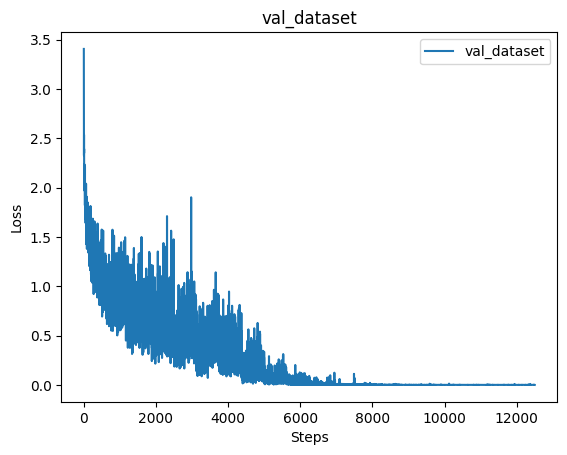

In [13]:
print_loss(val_losses, 'val_dataset')

In [14]:
criterion = nn.CrossEntropyLoss() 
test_losses = test_data(model=resnet9, test_loader=test_loader, criterion=criterion)

Test Loss: 0.5552501050862158, Test Accuracy: 87.64%


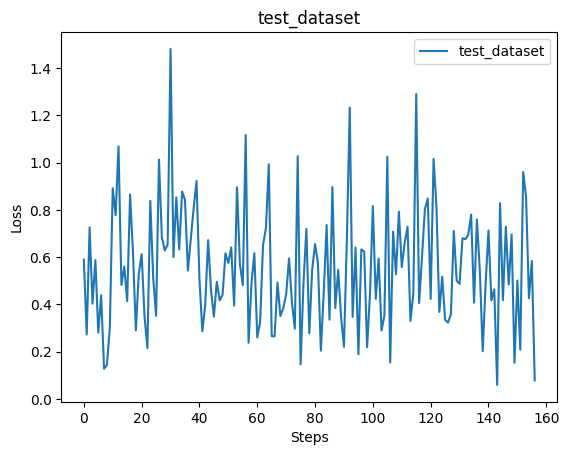

In [15]:
print_loss(test_losses, 'test_dataset')